# Анализ сервиса аренды самокатов GoFast

В наличии есть данные о некоторых пользователях приложения аренды самокатов из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

<b>Без подписки</b>
    
* абонентская плата отсутствует
    
* стоимость одной минуты поездки — 8 рублей
    
* стоимость старта (начала поездки) — 50 рублей


<b>С подпиской Ultra</b>

* абонентская плата — 199 рублей в месяц

* стоимость одной минуты поездки — 6 рублей

* стоимость старта — бесплатно

---

<b> Пользователи —</b> users_go.csv

* user_id — уникальный идентификатор пользователя

* name — имя пользователя

* age — возраст

* city — город

* subscription_type — тип подписки (free, ultra)


<b> Поeздки —</b> rides_go.csv

* user_id — уникальный идентификатор пользователя

* distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)

* duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

* date — дата совершения поездки


<b> Подписки —</b> subscriptions_go.csv

* subscription_type — тип подписки

* minute_price — стоимость одной минуты поездки по данной подписке

* start_ride_price — стоимость начала поездки

* subscription_fee — стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

Подключимся к таблицам и изучим общую информацию об имеющихся данных.

##### Таблица с пользователями

In [2]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
data_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


В таблице с пользователями хранятся данные о полутра тысячах пользователей, их имени, возрасте, городе и типе подписки.

##### Таблица с поездками

In [5]:
try:
    data_riders = pd.read_csv('/datasets/rides_go.csv')
except:
    data_riders = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [6]:
data_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
data_riders.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


В таблице с поездками хранятся данные о длительности поездки, дистанции, дате совершения поездки и id пользователя.

##### Таблица с подписками

In [8]:
try:
    data_sub = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_sub = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [9]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [10]:
data_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В таблице с типами подписки хранится информация о стоимости одной минуты поездки, стоимости старта поездки и ежемесячного платежа. Изучив информацию о типах подписки, видим, что для пользователей с подпиской ultra нет платы за старт поездки и стоимость одной минуты дешевле. Ежемесячная стоимость такой подписки составляет 199 рублей. Пользователям без подписки за каждый старт поездки необходимо заплатить 50 рублей, а также стоимость одной минуты поездки на 2 рубля дороже.

#### Шаг 2. Предобработка данных

Поменяем тип данных там, где это возможно. И добавим столбец.

Приведем столбец date к типу данных дат.

In [11]:
data_riders['date'] = pd.to_datetime(data_riders['date'], format = '%Y-%m-%d')

In [12]:
data_riders['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

In [13]:
data_riders['date'].describe()

/tmp/ipykernel_152/4233802546.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_riders['date'].describe()


count                   18068
unique                    364
top       2021-12-22 00:00:00
freq                       72
first     2021-01-01 00:00:00
last      2021-12-30 00:00:00
Name: date, dtype: object

Таблица с поездками содержит данные о поездах за 2021 год (с 01.01.2021 по 30.12.2021)

На основе данных столбца дат создадим столбец с месяцем поездки.

In [14]:
data_riders['month'] = data_riders['date'].dt.month

data_riders['month'].head(10)

0     1
1     1
2     4
3     8
4     8
5    10
6    10
7    11
8    11
9    11
Name: month, dtype: int64

Рассмотрим количество пропусков и дубликатов в таблицах.

In [15]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [16]:
data_riders.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [17]:
data_sub.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [18]:
data_users.duplicated().sum()

31

In [19]:
data_users.drop_duplicates(inplace=True)
data_users.duplicated().sum()

0

In [20]:
data_riders.duplicated().sum()

0

<b>Вывод</b>

Провели предобработку данных. Столбец с датами привели к типу дат, а также выделили месяц поездки в отдельный столбцец.
Изучили данные на наличие пропусков и дубликатов.
В имеющихся таблицах с данными пропущенных значений не оказалось. А дубликаты из таблицы с пользователями были удалены.

#### Шаг 3. Исследовательский анализ данных

На данном этапе, подготовив данные, проведем исследовательский анализ данных и опишем общую информацию о пользователях и поездках.

<b>Частота встречаемости городов</b>

In [21]:
count_users_by_city = data_users['city'].value_counts()
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [22]:
count_users_by_city['rate'] = round(data_users['city'].value_counts() / 
                                    count_users_by_city.sum(), 2) * 100
count_users_by_city['rate']

Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: city, dtype: float64

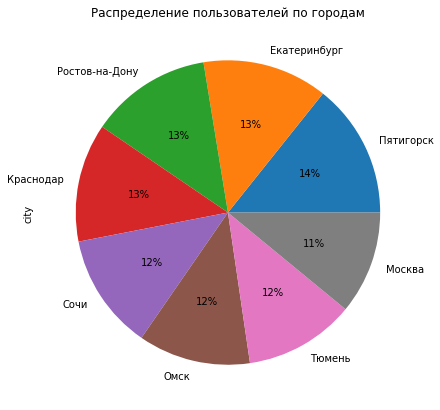

In [23]:
data_users['city'].value_counts().plot(
    kind = 'pie', 
    y = count_users_by_city,
    autopct = '%1.0f%%',
    figsize=(7,7), 
    title = 'Распределение пользователей по городам');

Больше всего пользователей из городов: Пятигорск, Екатеринбруг и Ростов-на-Дону.

<b>Соотношение пользователей с подпиской и без подписки</b>

In [24]:
count_sub = data_users['subscription_type'].value_counts()
count_sub

free     835
ultra    699
Name: subscription_type, dtype: int64

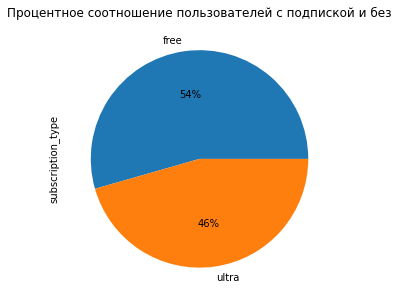

In [25]:
data_users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Процентное соотношение пользователей с подпиской и без');

Подпиской пользуются 46% пользователей.

<b>Возраст пользователей</b>

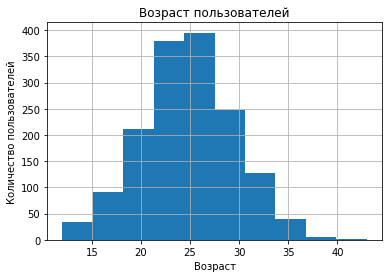

In [26]:
plt.hist(data_users['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [27]:
data_users['age'].sort_values().min()

12

In [28]:
data_users['age'].sort_values().max()

43

In [29]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст пользователей сервиса аренды самокатов составляет от 12 до 43 лет. Большая часть пользователей (75%) до 28 лет. Средний возраст пользоватлей 25 лет.

<b>Расстояние, которое пользователь преодолел за одну поездку</b>

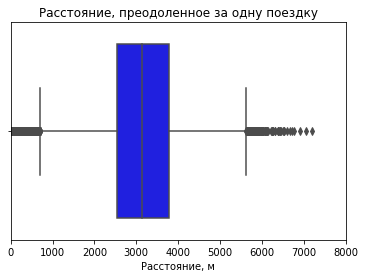

In [30]:
sns.boxplot(x=data_riders['distance'], color='blue')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 8000)

In [31]:
round(data_riders['distance'].sort_values(), 2).min()

0.86

In [32]:
round(data_riders['distance'].sort_values(), 2).max()

7211.01

In [33]:
data_riders['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Дистанция одной поездки по данным таблицы составляет от 0,8 м до 7,2 км. В среднем пользователи проезжают 3 километра за одну поездку.

<b>Продолжительность поездок</b>

sns.boxplot(x = data_riders['duration'], color='blue')
plt.title('Время, проведенное в поездке')
plt.xlabel('Время, минуты')
_ = plt.xlim(0, 45)

In [34]:
data_riders['duration'].sort_values().min()

0.5

In [35]:
data_riders['duration'].sort_values().max()

40.82396261922424

In [36]:
data_riders['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Длительность поездок составляет от 0,5 до 40 минут. В среднем одна поездка длится 17 минут.

Добавим столбец со скоростью поездки, чтобы дополнительно проанализировать данные на наличие аномальных значений

In [37]:
data_riders['speed'] = data_riders['distance']/data_riders['duration']

In [38]:
data_riders['speed'].describe()

count    18068.000000
mean       229.754352
std        735.936479
min          0.085552
25%        135.464046
50%        170.852249
75%        215.496668
max      14422.015489
Name: speed, dtype: float64

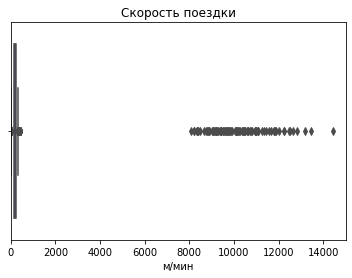

In [39]:
sns.boxplot(x = data_riders['speed'], color='blue')
plt.title('Скорость поездки')
plt.xlabel('м/мин')
_ = plt.xlim(0, 15000)

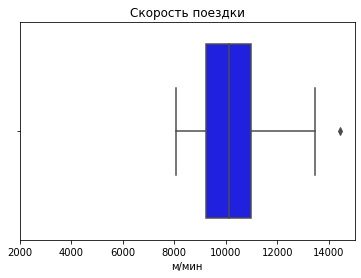

In [40]:
sns.boxplot(x = data_riders[data_riders['speed'] > 8000]['speed'], color='blue')
plt.title('Скорость поездки')
plt.xlabel('м/мин')
_ = plt.xlim(2000, 15000)

In [41]:
data_riders[data_riders['speed'] > 8000]['speed'].describe()

count       95.000000
mean     10226.353097
std       1316.508209
min       8060.616017
25%       9223.021640
50%      10105.538822
75%      10976.918198
max      14422.015489
Name: speed, dtype: float64

In [42]:
data_riders[data_riders['speed'] > 8000].describe()

,user_id,distance,duration,month,speed
count,95.000000,95.000000,95.0,95.000000,95.000000
mean,1092.210526,5113.176549,0.5,6.484211,10226.353097
std,244.028551,658.254104,0.0,3.709858,1316.508209
min,701.000000,4030.308008,0.5,1.000000,8060.616017
25%,901.000000,4611.510820,0.5,3.000000,9223.021640
50%,1069.000000,5052.769411,0.5,6.000000,10105.538822
75%,1310.500000,5488.459099,0.5,10.000000,10976.918198
max,1524.000000,7211.007745,0.5,12.000000,14422.015489


Заметили аномальные значения в соотношении пройденной дистанции и времени поездки. 95 поездок, длительность которых составляла полминуты, в то время как пройденная дистанция от 4 до 7 км. Можем предположить что у нас ошибка в данных, т.к. всего таких значений 95, что является 0,5% от всей таблицы. Их не так много, поэтому не вижу смысла их удалять, считаю они не окажут сильное влияние на другие выводы.

In [43]:
data_riders[data_riders['duration']==0.5]['duration'].count()

95

Все поездки по полминуты это и есть поездки с аномальными выбросами.

<b>Вывод</b>

Проанализировав имеющиеся данные, можем сделать следующие выводы:

<b><i>Частота встречаемости городов</i></b>

Количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Всего в данных представлены пользователи из 8 городов. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168. Связано это скорее всего с тем, что Пятигорск по размерам в несколько раз меньше Москвы, т.е. в Пятигорске удобнее брать самокат, чтобы куда-то добраться.

<b><i>Соотношение пользователей с подпиской и без подписки</i></b>

Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. Платной подпиской пользуются 699 пользователей, что соответственно является ~46%.

<b><i>Возраст пользователей</i></b>

Сервисом пользуются люди от 12 до 43 лет.
75% пользователей до 28 лет. Средний возраст пользователей - 25 лет.

<b><i>Расстояние, которое пользователь преодолел за одну поездку</i></b>

Самая короткая дистанция - 0.86 км
Самая длинная - 7.2 км
В основном пользователи проезжают от 2.5 км до 4 км.

<b><i>Продолжительность поездок</i></b>

Самые короткие поездки - по пол минуты. При этом изучив данные немного глубже, заметили, что в этих поездках аномально большие значения дистанций поездки. Всего таких поездок 95. Это составляет пол процента от всех поездок, что сильно не повлияет на последующие выводы, поэтому данные решили не удалять.
Самая длинная поездка заняла 40 минут.
В основном же длительность поездки состовляет 13 - 22 минут.

#### Шаг 4. Объединение данных

<b>Объединим данные о пользователях, поездках и подписках в один датафрейм.</b>

In [44]:
full_data = data_users.merge(data_riders)
full_data = full_data.merge(data_sub)
full_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,172.264021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,165.493673,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,121.011887,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,145.577402,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,153.381465,6,0,199


In [45]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   speed              18068 non-null  float64       
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

<b>Создадим два датафрейма с данными о пользователях без подписки и с подпиской</b>

In [46]:
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,168.337961,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,52.168168,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,200.055381,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,123.267611,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,174.858655,8,50,0


In [47]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,172.264021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,165.493673,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,121.011887,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,145.577402,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,153.381465,6,0,199


<b>Визуализируем информацию о расстоянии на бесплатном и платном тарифах</b>

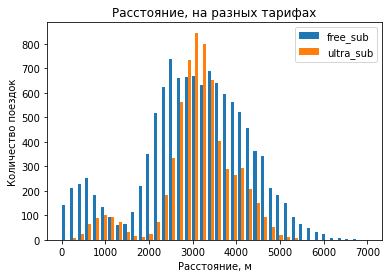

<Figure size 2880x2880 with 0 Axes>

In [48]:
plt.hist([free_sub['distance'], ultra_sub['distance']], bins=40, range = (0, 7000), label=['free_sub', 'ultra_sub'])
plt.title('Расстояние, на разных тарифах')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')
plt.figure(figsize=(40,40))
plt.show()

In [49]:
free_sub['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [50]:
ultra_sub['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Пользователи с бесплатной подпиской совершают более длительные поздки, чем пользователи с платной подпиской. Поездок с бесплатной подпиской почти в два раза больше.

<b>Визуализируем информацию о времени на бесплатном и платном тарифах</b>

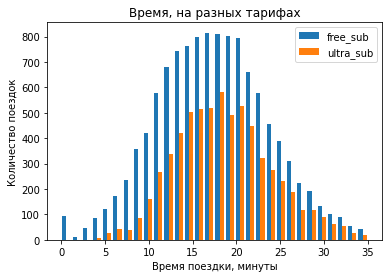

<Figure size 2880x2880 with 0 Axes>

In [51]:
plt.hist([free_sub['duration'], ultra_sub['duration']], bins=30, range = (0, 35), label=['free_sub', 'ultra_sub'])
plt.title('Время, на разных тарифах')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')
plt.figure(figsize=(40,40))
plt.show()

In [52]:
free_sub['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [53]:
ultra_sub['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

<b>Вывод</b>

Объединили данные о пользователях, поездках и тарифах в один датафрейм - <i>full_data</i>.

Также были выделены два датафрейма на основе <i>full_data</i>:

<i>free_sub</i> - Информация о пользователях с бесплатным тарифом

<i>ultra_sub</i> - Информация о пользователях с платным тарифом

Визуализирована информация о расстоянии и времени для каждого из тарифов.

Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали даже 6, 6.5 км.

Платный тариф. В основном время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе.

#### Шаг 5. Подсчёт выручки

<b>Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц. А так же добавим столбец с помесячной выручкой.</b>

In [54]:
full_data['duration'] = np.ceil(full_data['duration'])

In [55]:
total_data = pd.pivot_table(full_data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min,
                                      'minute_price' : min,
                                      'start_ride_price' : min,
                                      'subscription_fee' : min})
total_data.sort_values(by='month').head()

distance  duration  minute_price  name  start_ride_price  \
month user_id                                                                 
1     1         7027.511294      42.0             6     2                 0   
      1061     12637.249630      43.0             8     3                50   
      1063      3276.362299      10.0             8     1                50   
      1064      5297.324649      15.0             8     1                50   
      1065     14547.099333      99.0             8     4                50   

               subscription_fee subscription_type  
month user_id                                      
1     1                     199             ultra  
      1061                    0              free  
      1063                    0              free  
      1064                    0              free  
      1065                    0              free

In [56]:
total_data.rename(columns = {'name' : 'count_tips'}, inplace = True)
total_data.sort_values(by='month').head()

distance  duration  minute_price  count_tips  \
month user_id                                                     
1     1         7027.511294      42.0             6           2   
      1061     12637.249630      43.0             8           3   
      1063      3276.362299      10.0             8           1   
      1064      5297.324649      15.0             8           1   
      1065     14547.099333      99.0             8           4   

               start_ride_price  subscription_fee subscription_type  
month user_id                                                        
1     1                       0               199             ultra  
      1061                   50                 0              free  
      1063                   50                 0              free  
      1064                   50                 0              free  
      1065                   50                 0              free

In [57]:
total_data['revenue_per_month'] = total_data['start_ride_price'] * total_data['count_tips'] + total_data['minute_price'] * total_data['duration'] + total_data['subscription_fee']
total_data.head()

distance  duration  minute_price  count_tips  \
month user_id                                                    
1     1        7027.511294      42.0             6           2   
      3        3061.777147      13.0             6           1   
      5        3914.646990      13.0             6           1   
      7        6478.080979      28.0             6           2   
      12       3577.151148      33.0             6           1   

               start_ride_price  subscription_fee subscription_type  \
month user_id                                                         
1     1                       0               199             ultra   
      3                       0               199             ultra   
      5                       0               199             ultra   
      7                       0               199             ultra   
      12                      0               199             ultra   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0

<b>Вывод</b>

На основе датафрема создали сводную таблицу с агрегированными данными суммарного расстояния, количества поездок, времени и типом подписки по каждому пользователю в разрезе месяца. И добавили столбец с ежемесячной выручкой, принесенной каждым пользователем.

#### Шаг 6. Проверка гипотез

##### 6.1

Проверим гипотезу: <b>Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе</b>.

H_0: Время (<i>duration</i>) пользователей на подписке <i>ultra</i> = время (<i>duration</i>) пользователей на подписке <b>free</b>

H_1: Время (<i>duration</i>) пользователей на подписке <i>ultra</i> > время (<i>duration</i>) пользователей на подписке <b>free</b>

alpha = 0.05

In [58]:
ultra = ultra_sub['duration'] 

free = free_sub['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


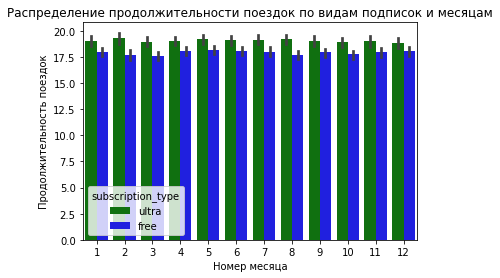

In [59]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data,
            palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

<b>Вывод</b>

Отвергли гипотезу о том, что время поездки пользователей на тарифе <b>ultra</b> равно времени поездки пользователей на тарифе <b>free</b>. По графику также заметно, что в среднем пользователи с подпиской трятят в месяц больше времни на поездки.

##### 6.2

Проверим гипотезу: <b>пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.</b>

H_0: Расстояние (<i>distance</i>) пользователей на подписке <i>ultra</i> = 3130 метров

H_1: Расстояние (<i>distance</i>) пользователей на подписке <i>ultra</i> > 3130 метров

alpha = 0.05

In [60]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = .05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


<b>Вывод</b>

Мы принимаем нулевую гипотезу о том что среднее расстояние, которое проехали пользователи на тарифе <b>ultra</b> не превышает 3130 метров. Что является оптимальным с точки зрения износа самоката.

##### 6.3

Проверим гипотезу: <b>помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки</b>

H_0: Выручка (<i>revenue_per_month</i>) пользователей на подписке <i>ultra</i> = выручка (<i>revenue_per_month</i>) пользователей на подписке <b>free</b>

H_1: Выручка (<i>revenue_per_month</i>) пользователей на подписке <i>ultra</i> > выручка (<i>revenue_per_month</i>) пользователей на подписке <b>free</b>

alpha = 0.05

In [61]:
ultra_per_mnth = total_data.loc[total_data.subscription_type == 'ultra', 'revenue_per_month'] 

free_per_mnth = total_data.loc[total_data.subscription_type == 'free', 'revenue_per_month'] 


results = st.ttest_ind(ultra_per_mnth, 
                       free_per_mnth,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


<b>Вывод</b>

Проверив гипотезу, можем утверждать, что выручка с пользователей на подписке <b>ultra</b> превышает выручку с пользователей на подписке <b>free</b>.

##### 6.4

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ:

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

# Общий вывод

Для данного проекта было использовано 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках.

После подключения к данным провели их предобработку, изучили общую информацию об имеющихся данных. Проверили данные на пропуски, их не оказалось ни в одной таблице. Поменяли тип данных у столбца <i>date</i> из датафрейма <i>data_riders</i> к типу даты. Также добавили столбец <i>month</i> с номером месяца. Удалили дубликаты строк из данных с пользователями.

<b>Провели исследовательский анализ данных:</b>

Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Пользователи сервиса представлены в 8 городах.  Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168.

Пользователей, использующих бесплатную подписку больше - 835 человек, 54% от общего числа пользователей. Платной подпиской пользуется 699 пользователей, что составляет 46%.

Возраст пользователей сервиса от 12 до 43 лет.

В среднем длительность поездки составляет 17 минут. 
Среднее расстояние, которое проезжают поользователи - 3 км.

Добавили столбец со скоростью, чтобы проверить данные на наличие аномальных значений. Заметили, что есть поездки, в которых время составляет пол минуты, при том, что дистанция поездки - несколько километров. Таких поездок оказалось 95, что составляет 0,5% от всех данных.

Объединили данные о пользователях, поездках и подписках в один датафрейм. И на его основе создали два датафрема в разрезе типов подписки.

Затем визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.

Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали до 7 км.

Платный тариф. В основном время составляет от 15 до 25 минут. Пик расстояния приходится на 3км, максимально расстояние 5,6 км

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм <i>total_data</i>. Добавили в датафрейм <i>total_data</i> столбец с помесячной выручкой от каждого пользователя<i>revenue_per_month</i>.

<b>Проверили гипотезы:</b>

Отвергли гипотезу о том, что время поездки пользователей на платном тарифе равно времени поездки пользователей на тарифе бесплатном.

Приняли нулевую гипотезу о том, что среднее расстояние, которое проехали пользователи на платном тарифе не превышает 3130 метров. Что является оптимальным с точки зрения износа самоката.

Приняли гипотезу, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. Для компании более выгодными считаются клиенты с подпиской.

Сформировали гипотезы и опредили какой метод сравнения использовать для их проверки. 